<a href="https://colab.research.google.com/github/LapTQ/mlapplications/blob/main/ML_applications.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Facial beauty perception

**Note**: This is just for fun, everyone is beautiful in a special way.

In [ ]:
#@title Import and load model

!git clone https://github.com/LapTQ/mlapplications.git
!pip install mtcnn

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

import tensorflow as tf
from tensorflow.keras.preprocessing import image

from google.colab import files

def plot_img(img, scores, labels):
    scores = [np.squeeze(i) for i in scores]
    plt.imshow(img) 
    
    if len(labels) == 2:
        plt.title('true: %.2f | pred: %.2f' % (scores[0], scores[1]))
    else:
        plt.title('%s: %.2f' % (labels[0], scores[0]))

    plt.axis('off')

from IPython.display import display, Javascript
from google.colab.output import eval_js
from google.colab import files
from base64 import b64encode, b64decode
import cv2
import PIL
import io
from mtcnn.mtcnn import MTCNN

def video_stream():
    js = Javascript('''
        var video;
        var div = null;
        var stream;
        var captureCanvas;
        var imgElement;
        var labelElement;
        
        var pendingResolve = null;
        var shutdown = false;
        
        function removeDom() {
        stream.getVideoTracks()[0].stop();
        video.remove();
        div.remove();
        video = null;
        div = null;
        stream = null;
        imgElement = null;
        captureCanvas = null;
        labelElement = null;
        }
        
        function onAnimationFrame() {
        if (!shutdown) {
            window.requestAnimationFrame(onAnimationFrame);
        }
        if (pendingResolve) {
            var result = "";
            if (!shutdown) {
            captureCanvas.getContext('2d').drawImage(video, 0, 0, video.videoWidth, video.videoHeight);
            result = captureCanvas.toDataURL('image/jpeg', 0.8)
            }
            var lp = pendingResolve;
            pendingResolve = null;
            lp(result);
        }
        }
        
        async function createDom() {
        if (div !== null) {
            return stream;
        }

        div = document.createElement('div');
        div.style.border = '2px solid black';
        div.style.padding = '3px';
        div.style.width = '100%';
        div.style.maxWidth = '600px';
        document.body.appendChild(div);
        
        const modelOut = document.createElement('div');
        modelOut.innerHTML = "<span>Status:</span>";
        labelElement = document.createElement('span');
        labelElement.innerText = 'No data';
        labelElement.style.fontWeight = 'bold';
        modelOut.appendChild(labelElement);
        div.appendChild(modelOut);
            
        video = document.createElement('video');
        video.style.display = 'block';
        video.width = div.clientWidth - 6;
        video.setAttribute('playsinline', '');
        video.onclick = () => { shutdown = true; };
        stream = await navigator.mediaDevices.getUserMedia(
            {video: { facingMode: "environment"}});
        div.appendChild(video);

        imgElement = document.createElement('img');
        imgElement.style.position = 'absolute';
        imgElement.style.zIndex = 1;
        imgElement.onclick = () => { shutdown = true; };
        div.appendChild(imgElement);
        
        const instruction = document.createElement('div');
        instruction.innerHTML = 
            '<span style="color: red; font-weight: bold;">' +
            'When finished, click here or on the video to stop this demo</span>';
        div.appendChild(instruction);
        instruction.onclick = () => { shutdown = true; };
        
        video.srcObject = stream;
        await video.play();

        captureCanvas = document.createElement('canvas');
        captureCanvas.width = video.videoWidth;
        captureCanvas.height = video.videoHeight;
        window.requestAnimationFrame(onAnimationFrame);
        
        return stream;
        }
        async function stream_frame(label, imgData) {
        if (shutdown) {
            removeDom();
            shutdown = false;
            return '';
        }

        var preCreate = Date.now();
        stream = await createDom();
        
        var preShow = Date.now();
        if (label != "") {
            labelElement.innerHTML = label;
        }
                
        if (imgData != "") {
            var videoRect = video.getClientRects()[0];
            imgElement.style.top = videoRect.top + "px";
            imgElement.style.left = videoRect.left + "px";
            imgElement.style.width = videoRect.width + "px";
            imgElement.style.height = videoRect.height + "px";
            imgElement.src = imgData;
        }
        
        var preCapture = Date.now();
        var result = await new Promise(function(resolve, reject) {
            pendingResolve = resolve;
        });
        shutdown = false;
        
        return {'create': preShow - preCreate, 
                'show': preCapture - preShow, 
                'capture': Date.now() - preCapture,
                'img': result};
        }
        ''')

    display(js)
  
def video_frame(label, bbox):
    data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
    return data

def bbox_to_bytes(bbox_array):
    """
    Params:
            bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
    Returns:
            bytes: Base64 image byte string
    """
    # convert array into PIL image
    bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGB')
    iobuf = io.BytesIO()
    # format bbox into png for return
    bbox_PIL.save(iobuf, format='png')
    # format return string
    bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

    return bbox_bytes



def predict_image(img, mode):

    img_np = np.asarray(img)
    
    if mode == 'face extracted' or mode == 'face embedding':
        face_extractor = MTCNN()
        bboxes = face_extractor.detect_faces(img_np)
        faces = {'img': [], 'coord': []}
        def get_color(_):
            color = [80, 80, 40]
            color[_ % 3] *= (_ + 1)
            return color
        for _ in range(len(bboxes)):
            x1, y1, width, height = bboxes[_]['box']
            x1, y1 = abs(x1), abs(y1)
            y2, x2 = y1 + height, x1 + width
            face = img_np[y1:y2, x1:x2]
            target_size = max(width, height)
            face = tf.image.resize_with_pad(face, target_size, target_size)
            if mode == 'face extracted':
                face = tf.image.resize(face, (224, 224))
            else:
                face = tf.image.resize(face, (160, 160))
            faces['img'].append(face)
            faces['coord'].append((x1, y1, x2, y2))
            img = cv2.rectangle(img, (x1, y1), (x2, y2), get_color(_), 1)
        if len(bboxes) > 0:
            faces_ds = tf.data.Dataset.from_tensor_slices(faces['img']).batch(32)
            preds = model.predict(faces_ds)
            for _ in range(len(bboxes)):
                cv2.putText(img, "{:.2f}".format(np.squeeze(preds[_])),
                            (faces['coord'][_][0], faces['coord'][_][1] - 4), cv2.FONT_HERSHEY_SIMPLEX, 0.6,
                            get_color(_), 2)
                
    else:
        img_np = tf.image.resize_with_pad(img_np, 224, 224)
        preds = model.predict(np.expand_dims(img_np, axis=0))
        cv2.putText(img, "{:.2f}".format(np.squeeze(preds)),
                    (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.0,
                    (0, 255, 0), 3)


    return {'img': img, 'preds': preds}

models = {}
model_dict = {'without face extracted': 'mobile_net', 'face extracted': 'mobile_net_face', 'face embedding': 'face_embedding'}
for mode in model_dict:
    models[model_dict[mode]] = tf.keras.models.load_model('mlapplications/trained_models/fbp/' + model_dict[mode])

In [23]:
#@title Chọn mô hình (Select model)

mode = 'face embedding' #@param ['without face extracted', 'face extracted', 'face embedding']

model = models[model_dict[mode]]

Saving kha-ngan-ngay-cang-xinh-dep-nu-tinh-o-tuoi-24.jpg to kha-ngan-ngay-cang-xinh-dep-nu-tinh-o-tuoi-24 (3).jpg
Uploaded "kha-ngan-ngay-cang-xinh-dep-nu-tinh-o-tuoi-24.jpg" of 156803 bytes


(-0.5, 599.5, 403.5, -0.5)

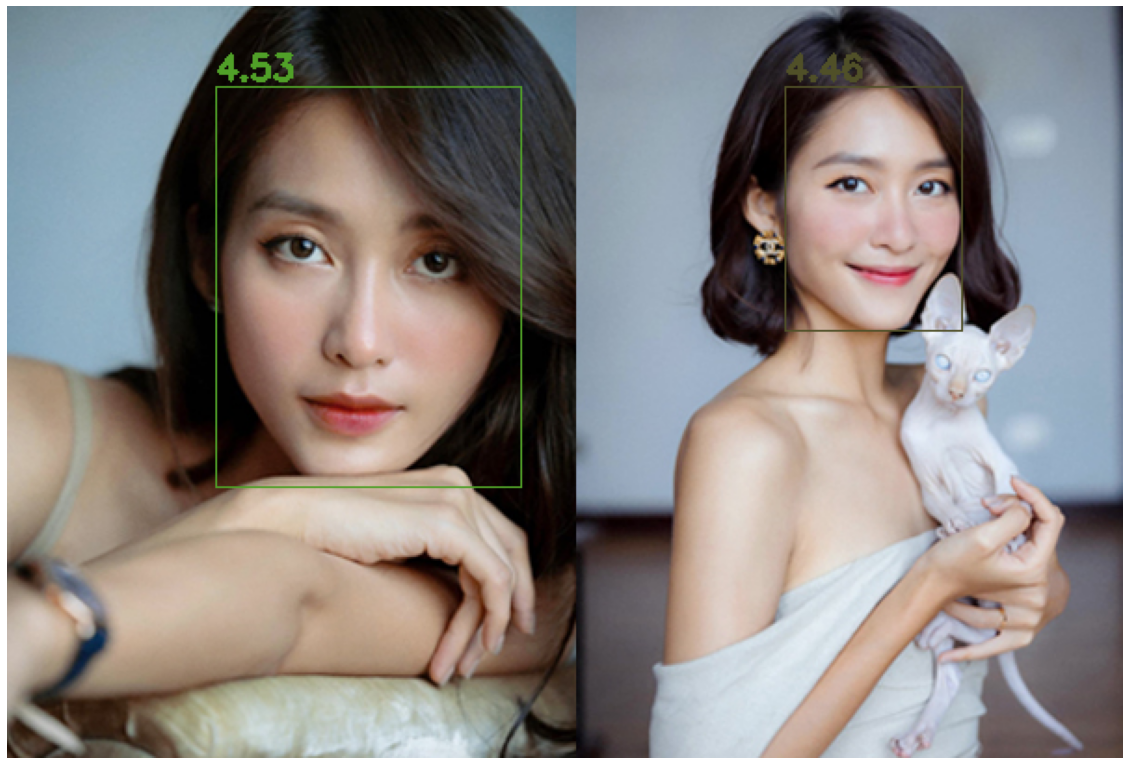

In [24]:
#@title Tải ảnh lên từ máy tính (Upload image from computer)

uploaded = files.upload()

for fn in uploaded.keys():
    print('Uploaded "{}" of {} bytes'.format(fn, len(uploaded[fn])))
    img = cv2.imread(fn)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = predict_image(img, mode)['img']

plt.figure(figsize=(min(img.shape[0], 20), min(img.shape[1], 20)))
plt.imshow(img)
plt.axis('off')

In [9]:
#@title Dự đoán thời gian thực (Real-time prediction)

video_stream()
label_html = 'Capturing...'
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    data = js_reply['img']
    binary = b64decode(data.split(',')[1])

    img = np.frombuffer(binary, dtype=np.uint8)
    img = cv2.imdecode(img, flags=1)
    img = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)

    try:
        img = predict_image(img, mode)['img']
    except:
        pass
    
    img_bytes = bbox_to_bytes(img)
    # update bbox so next frame gets new overlay
    bbox = img_bytes

<IPython.core.display.Javascript object>